## PASSO 0) Imports

In [72]:
import sys
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!{sys.executable} -m pip install chardet
import chardet

### 0.1) Funções Auxiliares

In [73]:
def find_outliers_tucker(series, threshold=1.5):
    """
    Retorna os índices dos valores obtidos como outliers após calculados os limites superiores
    e inferiores da Series em questão, utilizando o algoritmo de Tucker.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    lower_limit = q1 - threshold * iqr
    upper_limit = q3 + threshold * iqr

    filtered_series = series[(series < lower_limit) | (series > upper_limit)]
    
    return filtered_series.index

def imputa_rua(bairro, df):
    return df[bairro]

def imputa_bairro(rua, df):
    rua_formatted = rua.split(',')[0]
    imoveis = df.loc[df['Rua'] == rua_formatted]

    if imoveis.shape[0] == 0:
        bairro = None
    else:
        bairro = imoveis['Bairro'].unique()[0]

    return bairro

def jupyter_settings():
    %matplotlib inline
    warnings.filterwarnings('ignore')

    plt.rcParams['figure.figsize'] = (24, 12)
    plt.rcParams['font.size'] = 24
    pd.set_option('display.float_format', '{:.2f}'.format)
    pd.set_option('display.max_columns', 100)

    sns.set()

jupyter_settings()

### 0.2) Carregando os Dados

Carregando **dataset de imóveis** à venda na cidade de São Paulo

In [74]:
df_imoveis = pd.read_csv('./dados/dados_imoveis.csv')
df_imoveis.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000


# FASE 2
___

## PASSO 1) Descrição dos Dados

In [75]:
df1_imoveis = df_imoveis.copy()

In [76]:
print('Número de linhas: ', df1_imoveis.shape[0])
print('Número de colunas: ', df1_imoveis.shape[1])

Número de linhas:  10008
Número de colunas:  8


In [77]:
df1_imoveis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rua        6574 non-null   object
 1   Bairro     9996 non-null   object
 2   Cidade     10008 non-null  object
 3   Metragem   10008 non-null  int64 
 4   Quartos    10008 non-null  int64 
 5   Banheiros  10008 non-null  int64 
 6   Vagas      10008 non-null  int64 
 7   Valor      10008 non-null  object
dtypes: int64(4), object(4)
memory usage: 625.6+ KB


### 1.1) Tipos dos Dados

In [78]:
df1_imoveis.dtypes

Rua          object
Bairro       object
Cidade       object
Metragem      int64
Quartos       int64
Banheiros     int64
Vagas         int64
Valor        object
dtype: object

O tipo da coluna `Valor` está errado, devendo ser transformada para numérica. Escolhemos transformá-la para int64, o que será feito mais a frente na *seção 1.3*.

### 1.2) Valores Nulos

In [79]:
df1_imoveis.isna().sum()

Rua          3434
Bairro         12
Cidade          0
Metragem        0
Quartos         0
Banheiros       0
Vagas           0
Valor           0
dtype: int64

As variáveis `Rua` e `Bairro` possuem valores nulos que precisam ser tratados posteriormente.

### 1.3) Tratando Valores Nulos

Preenchendo valores nulos da coluna `Bairro`

In [80]:
df1_imoveis[df1_imoveis['Bairro'].isna()]

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
7263,"Rua Madalena de Morais, 3773",NaN,São Paulo,742,4,8,6,R$ 9.800\n /Mês
7956,Rua Vergueiro,NaN,São Paulo,103,3,2,2,R$ 640.000
7996,"Rua Alvorada do Sul, 3773",NaN,São Paulo,678,4,8,8,R$ 6.895.000
8126,"Rua Professor Eduardo Monteiro, 3773",NaN,São Paulo,550,3,5,6,R$ 4.000.000
8566,"Avenida Comendador Adibo Ares, 3773",NaN,São Paulo,694,4,6,6,R$ 3.890.000
8619,"Rua Alvorada do Sul, 3773",NaN,São Paulo,683,4,8,8,R$ 6.895.000
8739,"Rua Alvorada do Sul, 3773",NaN,São Paulo,683,4,8,8,R$ 6.895.000
8868,"Rua Professor Eduardo Monteiro, 3773",NaN,São Paulo,555,3,5,6,R$ 4.000.000
8943,"Rua Santo Eufredo, 3773",NaN,São Paulo,846,4,8,8,R$ 30.000\n /Mês
8992,"Rua Professor Eduardo Monteiro, 3773",NaN,São Paulo,555,3,5,6,R$ 4.000.000


In [81]:
df1_imoveis.loc[df1_imoveis['Rua'] == 'Rua Madalena de Morais']

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
1333,Rua Madalena de Morais,Jardim Leonor,São Paulo,950,4,3,4,R$ 4.000.000
3155,Rua Madalena de Morais,Jardim Leonor,São Paulo,800,5,8,6,R$ 8.000.000
7458,Rua Madalena de Morais,Jardim Leonor,São Paulo,726,4,8,9,R$ 4.500.000


Nota-se que existem imóveis no dataset que são da mesma Rua e que algum deles possui o valor correto da coluna Bairro. Basta imputar-mos estes valores aos imóveis com o dado faltante, para isso iremos criar um função `imputa_bairro()` que será definida na *seção 0.2*.

In [82]:
# removendo os valores nulos da coluna Bairro atraves da funcao imputa_bairro()
df1_imoveis['Bairro'] = df1_imoveis.apply(lambda x: x['Bairro'] if pd.notnull(x['Bairro']) \
                                else imputa_bairro(x['Rua'], df1_imoveis), axis=1)

In [83]:
# checando novamente o número de valores nulos na coluna bairro após a primeira limpeza
df1_imoveis.isna().sum()[df1_imoveis.isna().sum() > 0]

Rua       3434
Bairro       1
dtype: int64

Nota-se que restou apenas um imóvel com valor nulo na coluna `Bairro`, o qual nós iremos dropar do dataset.

In [84]:
# dropando o dado com valor nulo
df1_imoveis.dropna(subset=['Bairro'], inplace=True)

# checando novamente a quantiadde de valores nulos
print(f'Total de valores nulos na coluna Bairro = {df1_imoveis["Bairro"].isna().sum()}')

Total de valores nulos na coluna Bairro = 0


Preenchendo valores nulos da variável `Rua`

In [85]:
df1_imoveis.loc[df1_imoveis['Rua'].isna(), :].head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
11,NaN,Jardim Luzitânia,São Paulo,436,4,3,3,R$ 15.000
31,NaN,Parque da Lapa,São Paulo,220,4,4,3,R$ 849.000
56,NaN,Chácara Santo Antônio (Zona Sul),São Paulo,190,2,2,2,R$ 1.100.000
57,NaN,Jardim Guedala,São Paulo,650,4,6,4,R$ 5.500.000


Anteriormente nós garantimos que não existem dados com valores nulos para a coluna Bairro, uma das soluções para imputar a variável Rua seria obter uma Rua aleatório do mesmo bairro do dado em questão, outra solução seria simplesmente deletar todos os dados com valores de Rua faltante.

In [86]:
# Analisando a viabilidade de deletar todas as linhas com Rua faltante
tot_sem_rua = df1_imoveis.loc[df1_imoveis['Rua'].isna(), :].shape[0]
porc_sem_rua = tot_sem_rua / df_imoveis.shape[0] * 100
print(f'Porcentagem dos dados com valores faltantes para a coluan Rua = {porc_sem_rua:.2f}%')

Porcentagem dos dados com valores faltantes para a coluan Rua = 34.31%


Cerca de **35%** dos dados em nosso conjunto de dados não possuem valor para a variável Rua, o que é uma parcela bastante significativa. A simples exclusão destes dados acarretaria numa perca significativa da informação como um todo, por isso decidimos mantê-los e atribuir um valor aleatório de rua que seja do mesmo Bairro.

In [87]:
# agrupa os dados por bairro e obtem a rua mais frequente para cada bairro 
# ou None caso o bairro nao possua ruas no dataset
df_bairros = df1_imoveis.groupby('Bairro')['Rua'].agg(lambda x: x.mode().iat[0] if len(x.mode()) > 0 else None)

In [88]:
# removendo os valores nulos da coluna Bairro atraves da funcao imputa_bairro()
df1_imoveis['Rua'] = df1_imoveis.apply(lambda x: x['Rua'] if pd.notnull(x['Rua']) \
                                else imputa_rua(x['Bairro'], df_bairros), axis=1)

In [89]:
# checando novamente o número de valores nulos na coluna Rua após a primeira limpeza
df1_imoveis.isna().sum()[df1_imoveis.isna().sum() > 0]

Rua    173
dtype: int64

Nota-se que restaram 173 dados com valores nulos para a coluna Rua, uma redução significativa, esse são dados cujos bairros não possuem nenhuma rua cadastrada no dataset. Portanto, iremos dropar essas linhas.

In [90]:
df1_imoveis.dropna(subset=['Rua'], inplace=True)

Por fim, checando o valor atualizado de valores nulos que deve ser igual a 0. Nosso dataset agora está limpo.

In [91]:
df1_imoveis.isna().sum()

Rua          0
Bairro       0
Cidade       0
Metragem     0
Quartos      0
Banheiros    0
Vagas        0
Valor        0
dtype: int64

### 1.4) Tratando Variáveis com Tipos de Dados Incorretos

**Variável `Valor`**

Analisando os valores desta coluna descobrimos que ela não somente mostra o valor absoluto das casas, mas para algumas linhas ela mostra o valor do aluguel, podendo este ser diário, mensal ou anual.

Aluguel Diário

In [92]:
df1_imoveis[df1_imoveis['Valor'].str.contains('Dia')]

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
6639,Rua Sanharó,Jardim Guedala,São Paulo,572,4,6,7,R$ 15.000\n /Dia
7421,Rua Sanharó,Jardim Guedala,São Paulo,577,4,6,7,R$ 15.000\n /Dia


Aluguel Mensal

In [93]:
df_imoveis_alugar = df1_imoveis[df1_imoveis['Valor'].str.contains('Mês')]
df_imoveis_alugar.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
151,Rua Fonseca da Costa,Bosque da Saúde,São Paulo,650,4,6,12,R$ 11.000\n /Mês
156,Rua Sampaio Vidal,Jardim Paulistano,São Paulo,230,2,3,2,R$ 12.000\n /Mês
175,Rua Maestro Elias Lobo,Jardim Paulista,São Paulo,542,5,8,4,R$ 25.000\n /Mês
178,Rua Guararapes,Lapa,São Paulo,515,3,5,8,R$ 30.000\n /Mês
182,Rua Alvarenga,Butantã,São Paulo,400,4,3,4,R$ 10.000\n /Mês


In [94]:
alugar_prct = df_imoveis_alugar.shape[0] / df1_imoveis.shape[0]  * 100
print(f"Porcentagem de imoveis com alguel mensal: {alugar_prct:.2f}%")

Porcentagem de imoveis com alguel mensal: 8.62%


Aluguel Anual

In [95]:
df1_imoveis[df1_imoveis['Valor'].str.contains('Ano')]

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
6029,"Avenida Benjamim Mansur, 26",Instituto de Previdência,São Paulo,120,3,1,2,R$ 2.600\n /Ano
6718,"Avenida Benjamim Mansur, 26",Instituto de Previdência,São Paulo,125,3,1,2,R$ 2.600\n /Ano


In [96]:
# Deletando os imóveis de aluguel DIÁRIO
df1_imoveis.drop(df1_imoveis[df1_imoveis['Valor'].str.contains('Dia')].index, inplace=True)

# Deletando e salvando os imóveis de aluguel MENSAL
df1_imoveis.drop(df_imoveis_alugar.index, inplace=True)
df_imoveis_alugar.to_csv('./dados/dados_imoveis_alugar.csv')

# Deletando os imóveis de aluguel ANUAL
df1_imoveis.drop(df1_imoveis[df1_imoveis['Valor'].str.contains('Ano')].index, inplace=True)

A partir da nossa análise, descobrimos que o dataset de imóveis não somente compreende casas para vender, mas também casas para alugar. Essas casas correspondem a cerca de 8.47% do dataset completo, nossa decisão foi salvar esses dados em um arquivo .csv único, que separa essas casas do restante e nos permite posteriormente realizar análises direcionadas para elas, removendo-as do dataframe original.

**Resolvendo o tipo incorreto**

In [97]:
df1_imoveis['Valor'].sample(5)

7716     R$ 2.300.000
7284     R$ 1.040.000
3706    R$ 15.000.000
5365     R$ 1.100.000
4566     R$ 1.690.000
Name: Valor, dtype: object

Corrigindo o tipo de dado da variável `Valor`

In [98]:
# Casting da variável Valor de Object para int64
df1_imoveis['Valor'] = df1_imoveis['Valor']\
    .str.replace('R\$|,', '', regex=True)\
        .str.replace('.', '').str.strip()

In [99]:
df1_imoveis['Valor'] = df1_imoveis['Valor'].astype(int)
df1_imoveis['Valor'].sample(5)

3561    3950000
5016    1399900
3521     850000
6478    1690000
9695     650000
Name: Valor, dtype: int64

## PASSO 2) Criando Novas Colunas

In [100]:
df2_imoveis = df1_imoveis.copy()

#### Criando a coluna `Valor_m2`

Representa o valor médio do m2 para cada linha do dataframe.

In [101]:
df2_imoveis['Valor_m2'] = df2_imoveis['Valor'] / df2_imoveis['Metragem']
df2_imoveis['Valor_m2'].head()

0   7000.00
1   7459.68
2   3040.00
3   2209.68
4   5400.00
Name: Valor_m2, dtype: float64

## PASSO 3) Estatísticas de Resumo

In [102]:
df3_imoveis = df2_imoveis.copy()

In [103]:
# dividindo o dataframe em variáveis numéricas e categóricas
num_attr, cat_attr = df1_imoveis.select_dtypes(include=[int, float]), df1_imoveis.select_dtypes(exclude=[int, float])

**Variáveis Numéricas**

In [104]:
med_centralidade = num_attr.describe().rename({'count': 'Quantidade', 'max': 'Máximo', 'min': 'Mínimo', '50%': 'Mediana/Q2', 'mean': 'Média', '25%': 'Q1', '75%': 'Q3', 'std': 'Desvio Padrão'}).T

med_centralidade['Variância'] = med_centralidade['Desvio Padrão'] ** 2

med_centralidade

,Quantidade,Média,Desvio Padrão,Mínimo,Q1,Mediana/Q2,Q3,Máximo,Variância
Metragem,8982.00,439.09,7932.06,10.00,170.00,280.00,450.00,750000.00,62917622.92
Quartos,8982.00,3.45,1.04,1.00,3.00,3.00,4.00,16.00,1.08
Banheiros,8982.00,3.82,1.97,1.00,2.00,4.00,5.00,40.00,3.87
Vagas,8982.00,3.98,2.61,1.00,2.00,4.00,5.00,50.00,6.80
Valor,8982.00,3096161.82,3968416.66,13000.00,900000.00,1850000.00,3600000.00,65000000.00,15748330761846.62


Imprimindo boxplot para as variáveis numéricas

In [105]:
# removendo outliers
indexes_of_outliers = find_outliers_tucker(df3_imoveis['Metragem'])
df_cleaner = df3_imoveis.drop(indexes_of_outliers)
df_cleaner.shape

(8596, 9)

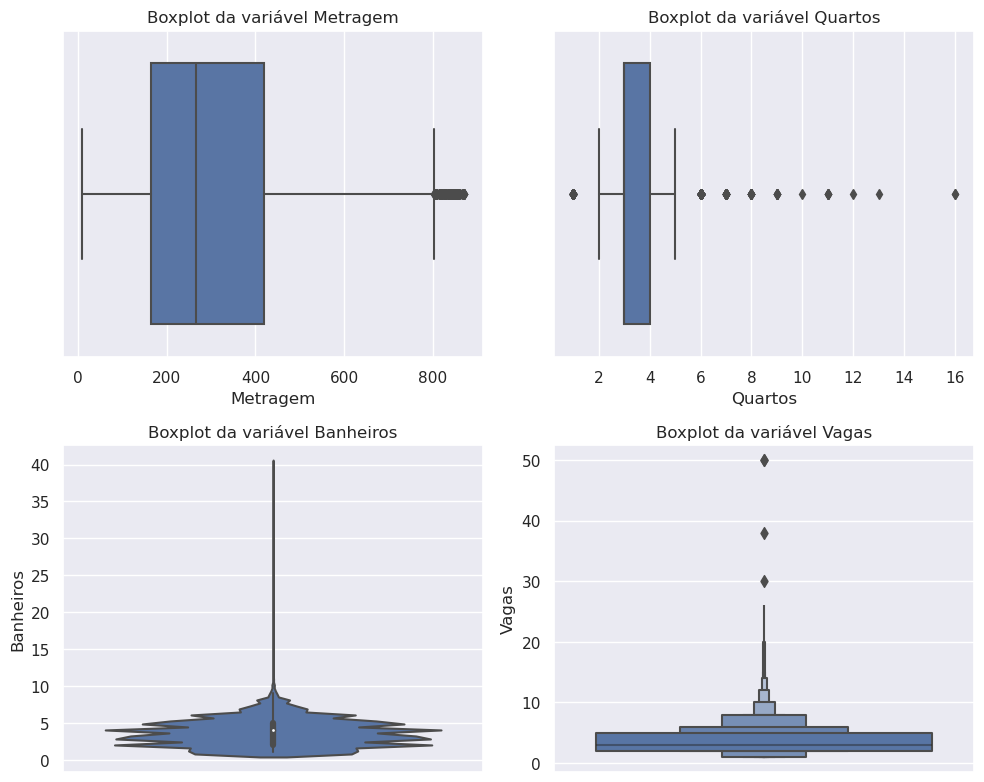

In [106]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.boxplot(data=df_cleaner, x='Metragem', ax=ax[0, 0])
ax[0, 0].set_title('Boxplot da variável Metragem')

# Gráfico de Densidade
sns.boxplot(data=df_cleaner, x='Quartos', ax=ax[0, 1])
ax[0, 1].set_title('Boxplot da variável Quartos')

# Gráfico de Boxplot
sns.violinplot(data=df_cleaner, y='Banheiros', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot da variável Banheiros')

# Gráfico de Scatter Plot
sns.boxenplot(data=df_cleaner, y='Vagas', ax=ax[1, 1])
ax[1, 1].set_title('Boxplot da variável Vagas')

plt.tight_layout()

plt.show()

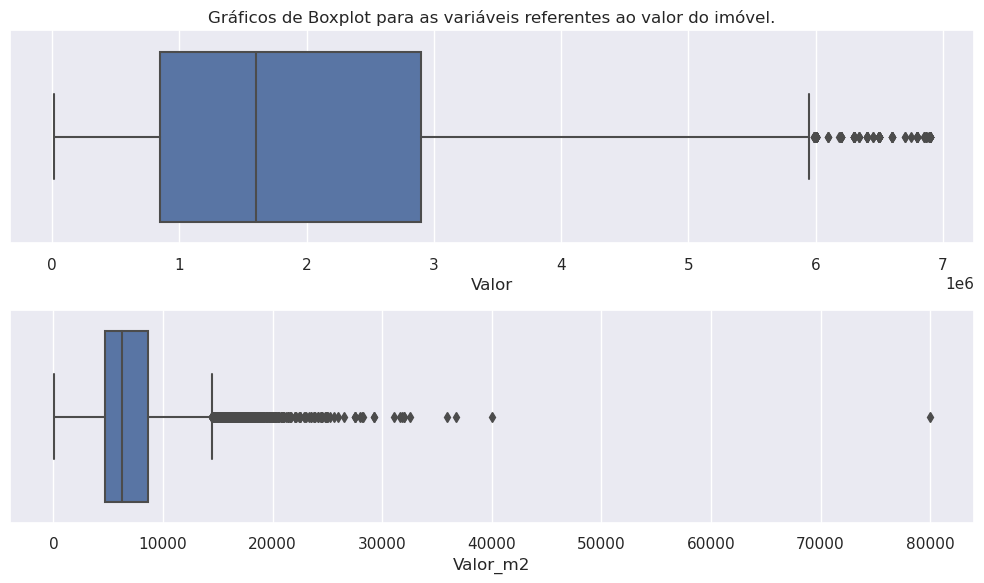

In [107]:
new_indexes_to_drop = find_outliers_tucker(df_cleaner['Valor'])
df_cleaner.drop(new_indexes_to_drop, inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

sns.boxplot(data=df_cleaner, x='Valor', ax=ax[0])

sns.boxplot(data=df_cleaner, x='Valor_m2', ax=ax[1])

ax[0].set_title('Gráficos de Boxplot para as variáveis referentes ao valor do imóvel.')
plt.tight_layout()

plt.show()

**Variáveis Categóricas**

In [108]:
cat_attr.describe().rename({'count': 'Quantidade', 'unique': 'Qtd. Valores Únicos', 'top': 'Moda', 'freq': 'Freq. da Moda'}).T

,Quantidade,Qtd. Valores Únicos,Moda,Freq. da Moda
Rua,8982,3014,Rua Alberto Faria,175
Bairro,8982,600,Alto de Pinheiros,369
Cidade,8982,1,São Paulo,8982
